In [80]:
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from typing import Type, Dict

from ds.wesad.datasets import SubjectDataset, subjects_data

In [29]:
ds_step_size = 5
device = "cuda"

figsize = (36, 12)

In [30]:
class ConvX(nn.Module):
    def __init__(
        self, in_planes, out_planes, kernel=3, stride=1, padding=None
    ):
        super(ConvX, self).__init__()
        padding = kernel // 2 if padding is None else padding
        self.conv = nn.Conv1d(
            in_planes,
            out_planes,
            kernel_size=kernel,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.bn = nn.BatchNorm1d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [58]:
class NetUpDownCoder3(nn.Module):
    def __init__(self):
        super(NetUpDownCoder3, self).__init__()
        self.seq = torch.nn.Sequential(
            ConvX(1, 4, kernel=3),
            ConvX(4, 8, kernel=3),
            nn.MaxPool1d(2),
            ConvX(8, 16, kernel=3),
            ConvX(16, 32, kernel=3),
            nn.MaxPool1d(2),
            ConvX(32, 16, kernel=3),
            ConvX(16, 8, kernel=3),
            nn.MaxPool1d(2),
            ConvX(8, 4, kernel=3),
            ConvX(4, 2, kernel=3),
            nn.Conv1d(2, 2, kernel_size=3, stride=1),
        )
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.seq(x)
        x = torch.flatten(x, 1)
        return self.softmax(x)

In [59]:
class NetUpDownCoder3_2(nn.Module):
    def __init__(self):
        super(NetUpDownCoder3_2, self).__init__()
        self.seq = torch.nn.Sequential(
            ConvX(1, 2, kernel=3),
            ConvX(2, 4, kernel=3),
            nn.Conv1d(4, 4, kernel_size=3, stride=2, padding=1),
            ConvX(4, 8, kernel=3),
            ConvX(8, 16, kernel=3),
            nn.Conv1d(16, 16, kernel_size=3, stride=2, padding=1),
            ConvX(16, 32, kernel=3),
            ConvX(32, 64, kernel=3),
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),
            ConvX(64, 32, kernel=3),
            ConvX(32, 16, kernel=3),
            nn.Conv1d(16, 16, kernel_size=3, stride=2, padding=1),
            ConvX(16, 8, kernel=3),
            ConvX(8, 4, kernel=3),
            nn.Conv1d(4, 4, kernel_size=3, stride=2, padding=1),
            ConvX(4, 2, kernel=3),
            nn.Conv1d(2, 2, kernel_size=2, stride=1),
        )
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.seq(x)
        x = torch.flatten(x, 1)
        return self.softmax(x)

In [60]:
def val(model, dl_test, return_valid_count_only=True):
    labels_ = []
    outputs_ = []
    with torch.no_grad():
        sum_ = 0
        for i, data in enumerate(dl_test):
            inputs, labels = data
            labels_.append(labels)
            inputs = (
                torch.unsqueeze(inputs, 1).to(torch.float32).to(device=device)
            )
            outputs = model(inputs).cpu()
            outputs = outputs.max(1).indices
            outputs_.append(outputs)
            eq = outputs == labels
            sum_ += eq.sum()

    return sum_ if return_valid_count_only else (sum_, labels_, outputs_)

In [61]:
subjects_test_datasets = {
    subject_id: SubjectDataset(
        subject_data,
        ds_type="test",
        step=ds_step_size,
    )
    for subject_id, subject_data in subjects_data.items()
}

In [62]:
def subjects_validate(net_class: Type[nn.Module], net_state_dict: Dict):
    accuracies = {}
    for subject_id, ds_test in subjects_test_datasets.items():
        dl_test = DataLoader(
            ds_test,
            batch_size=1,
            shuffle=True,
            num_workers=1,
            pin_memory=False,
            drop_last=True,
        )
        net = net_class().to(device=device)
        net.load_state_dict(net_state_dict)
        net.eval()
        accuracy = val(net, dl_test)
        accuracies[subject_id] = accuracy / len(ds_test)
    return accuracies

In [63]:
def net_compute(net_class: Type[nn.Module], states_path: Path):
    hist_state = {}
    for epoch_info_filename in tqdm(states_path.glob("*epoch*.pkl")):
        with open(epoch_info_filename, "rb") as f:
            epoch_info = pickle.load(f)
        hist_state[epoch_info.get("current_epoch")] = {
            "mean": epoch_info.get("rate"),
            "subjects": subjects_validate(
                net_class, epoch_info.get("net_state_dict")
            ),
        }

    for_plot = {
        "mean": [],
        **{id_: [] for id_ in hist_state.get(20).get("subjects", {}).keys()},
    }
    epochs = sorted(hist_state.keys())
    for epoch in epochs:
        values = hist_state[epoch]
        for_plot.get("mean").append(values.get("mean"))
        for subject, value in values.get("subjects").items():
            for_plot.get(subject).append(value.item())
    return epochs, for_plot

In [83]:
def _plt(epochs, for_plot, fig_title, *, figsize=(24, 7)):
    fig, axis = plt.subplots(1, 1, figsize=figsize)
    colors = plt.cm.tab20(np.linspace(0, 1, len(for_plot)))
    for i, (title, line) in enumerate(for_plot.items()):
        axis.plot(
            epochs,
            line,
            label=title,
            marker="o" if title == "mean" else None,
            color=colors[i],
        )
    axis.legend()
    plt.title(fig_title, fontdict={"fontsize": 16})
    plt.xticks(epochs, epochs)
    return plt, axis

In [65]:
epochs_asgd_5, for_plot_asgd_5 = net_compute(
    NetUpDownCoder3, Path("NetUpDownCoder3_ASGD_lr_5e-05")
)

0it [00:00, ?it/s]

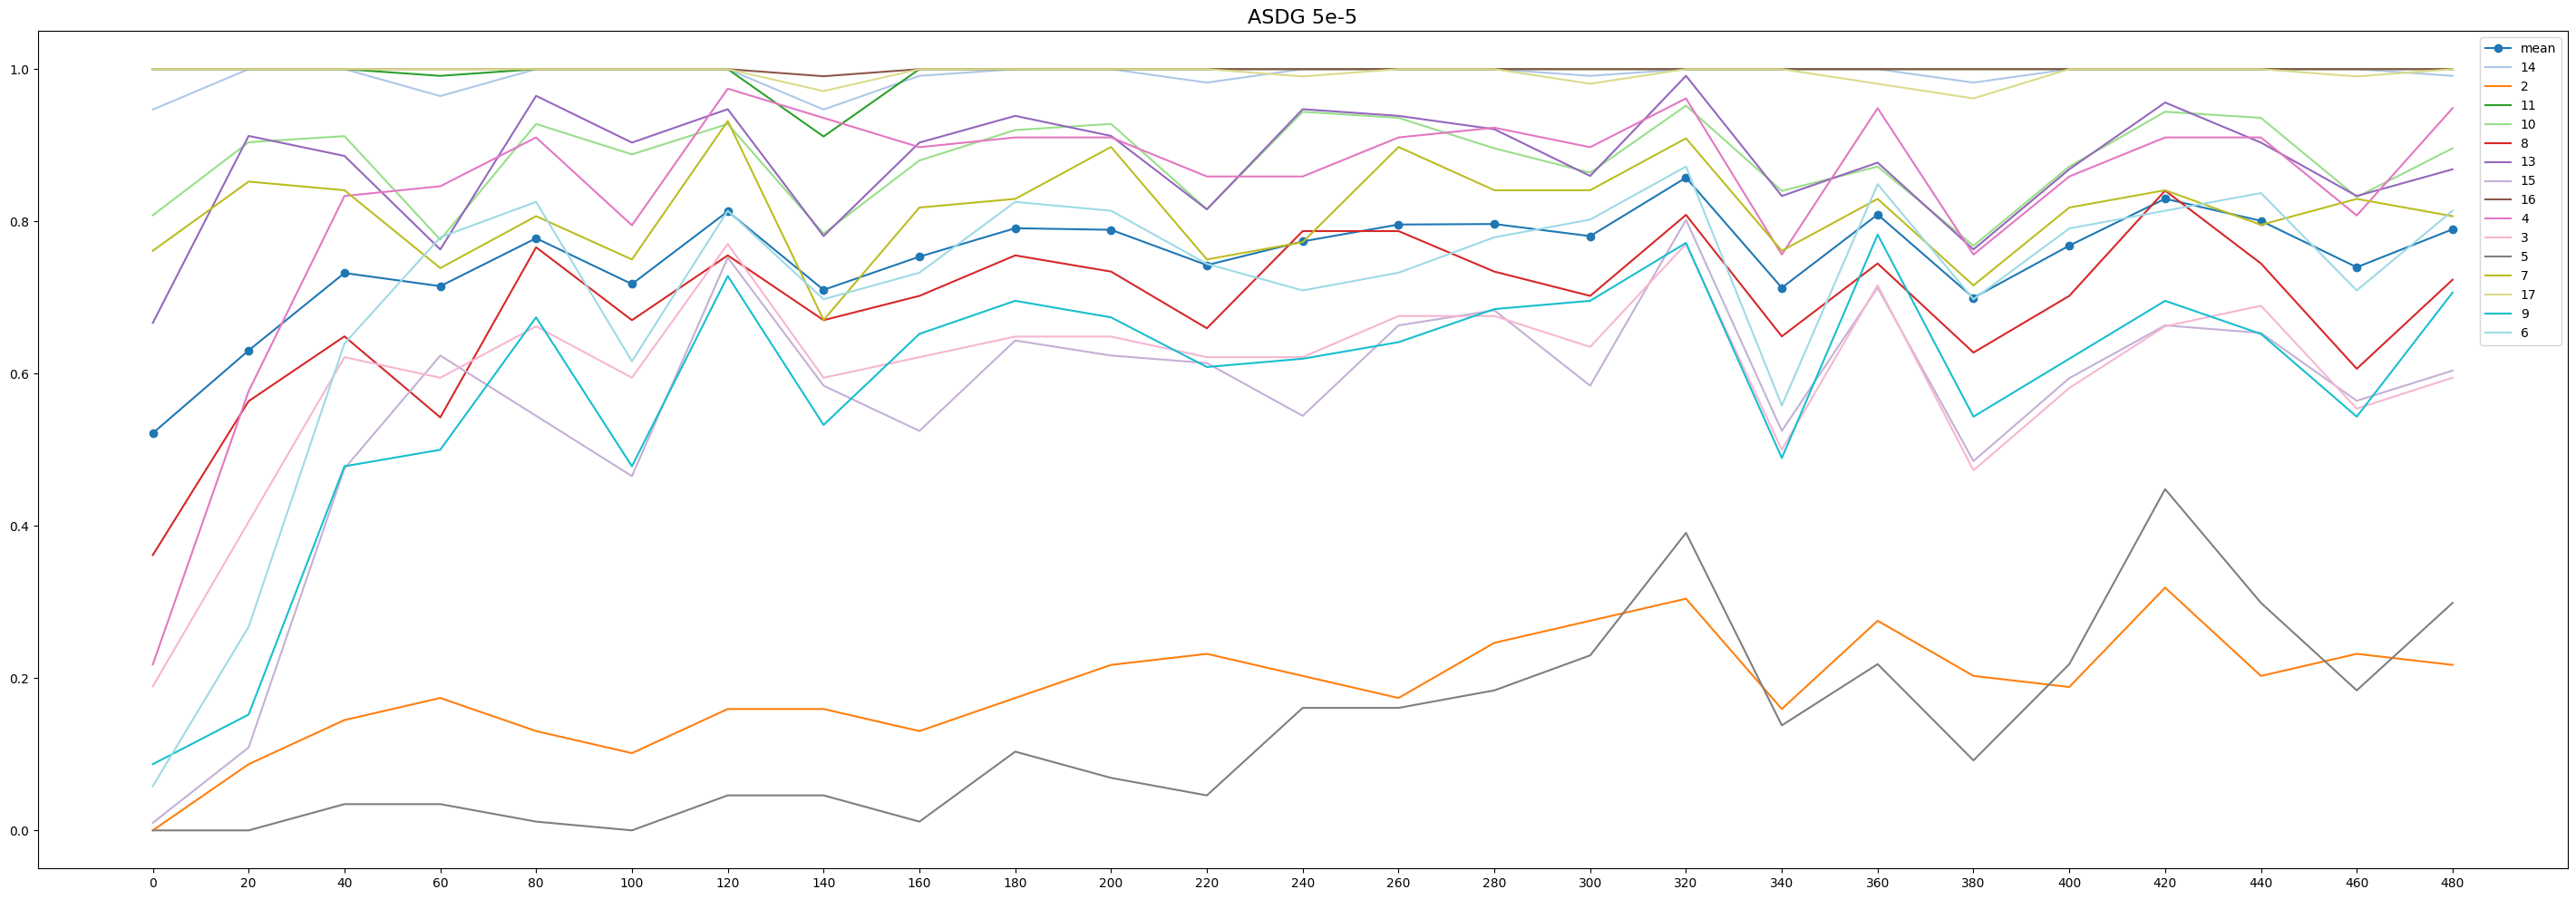

In [84]:
_plt(epochs_asgd_5, for_plot_asgd_5, "ASDG 5e-5", figsize=figsize)
pass

In [68]:
epochs_2_asgd_5, for_plot_2_asgd_5 = net_compute(
    NetUpDownCoder3_2, Path("NetUpDownCoder3_2_ASGD_lr_5e-05")
)

0it [00:00, ?it/s]

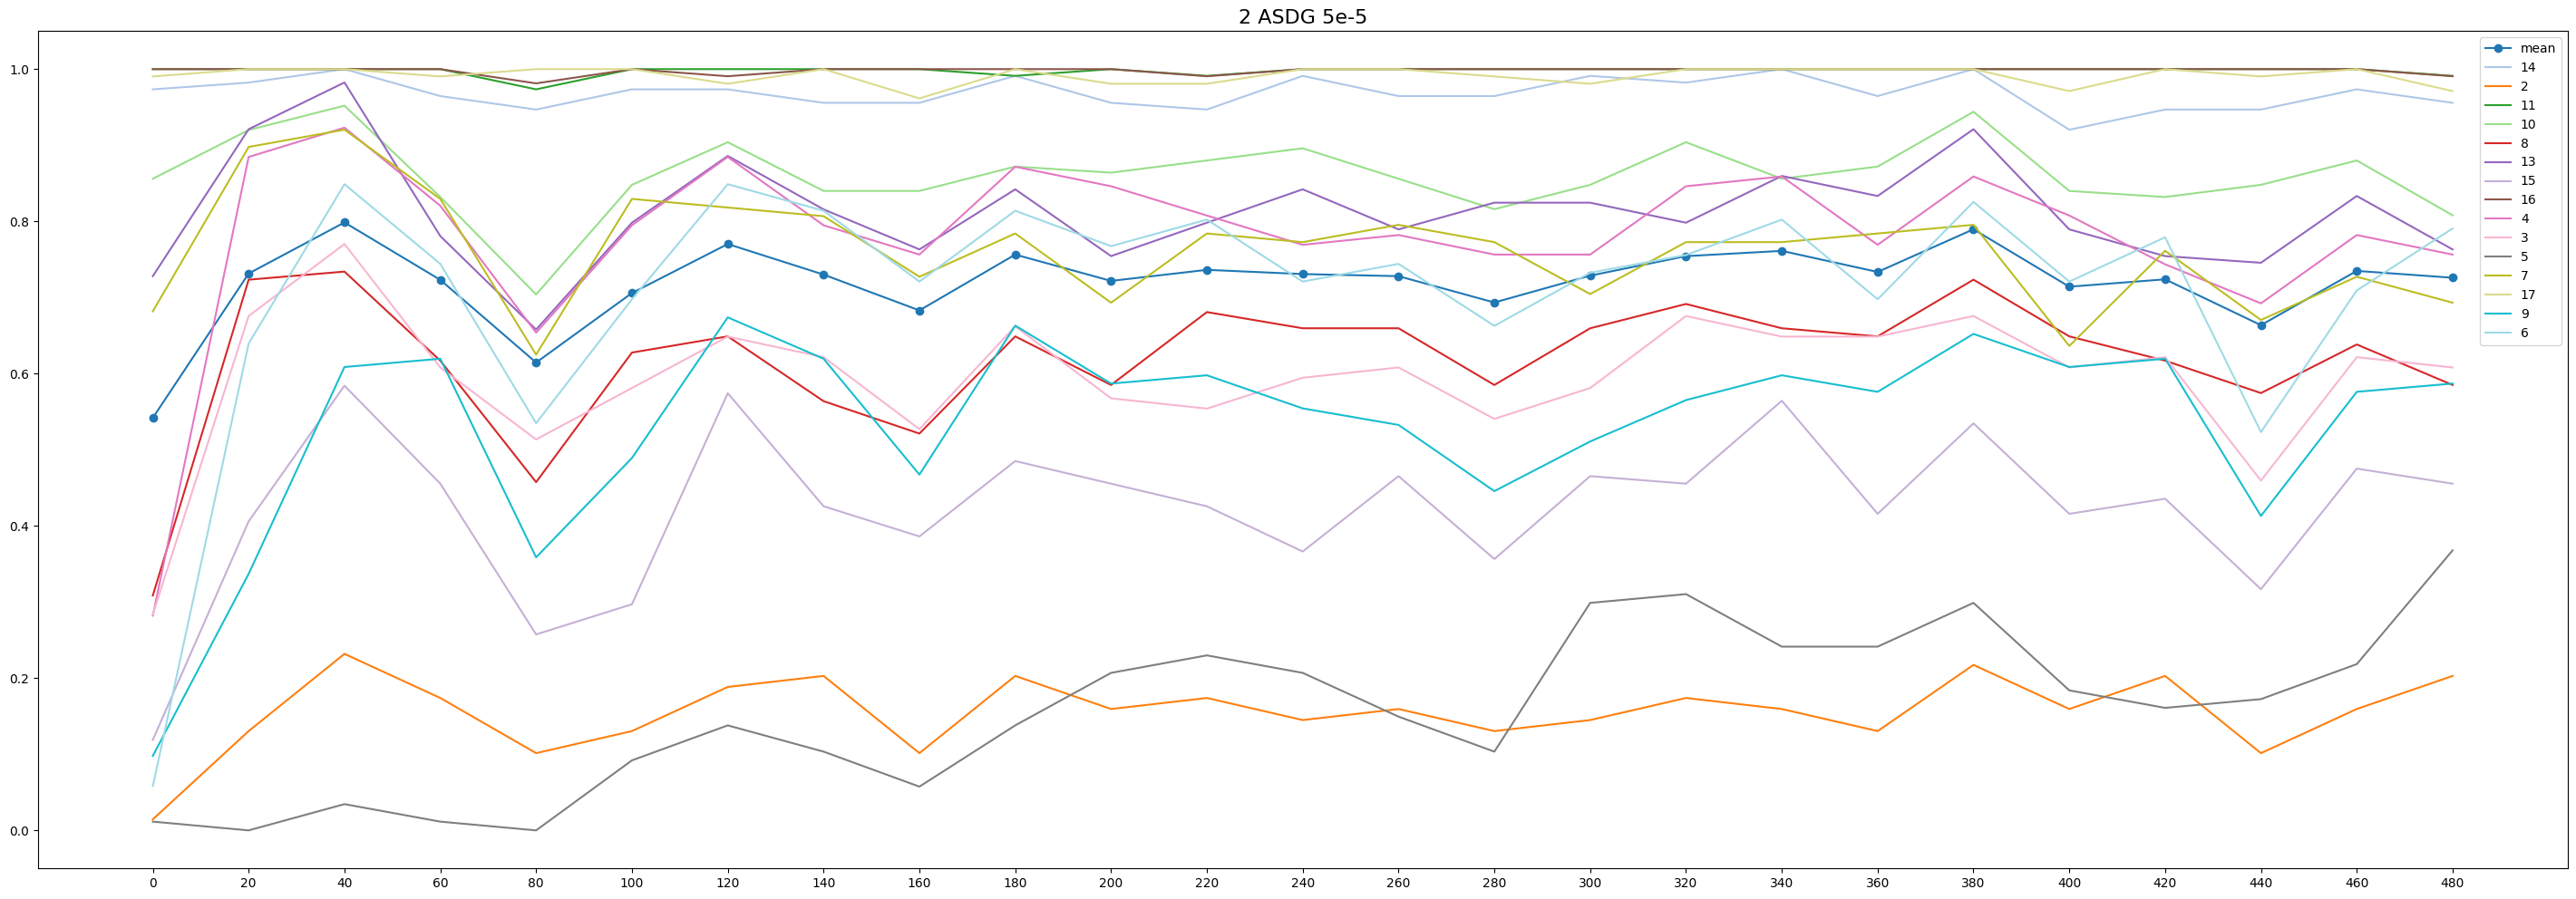

In [85]:
_plt(epochs_2_asgd_5, for_plot_2_asgd_5, "2 ASDG 5e-5", figsize=figsize)
pass

In [76]:
epochs_2_asgd_1, for_plot_2_asgd_1 = net_compute(
    NetUpDownCoder3, Path("NetUpDownCoder3_ASGD_lr_1e-05")
)

0it [00:00, ?it/s]

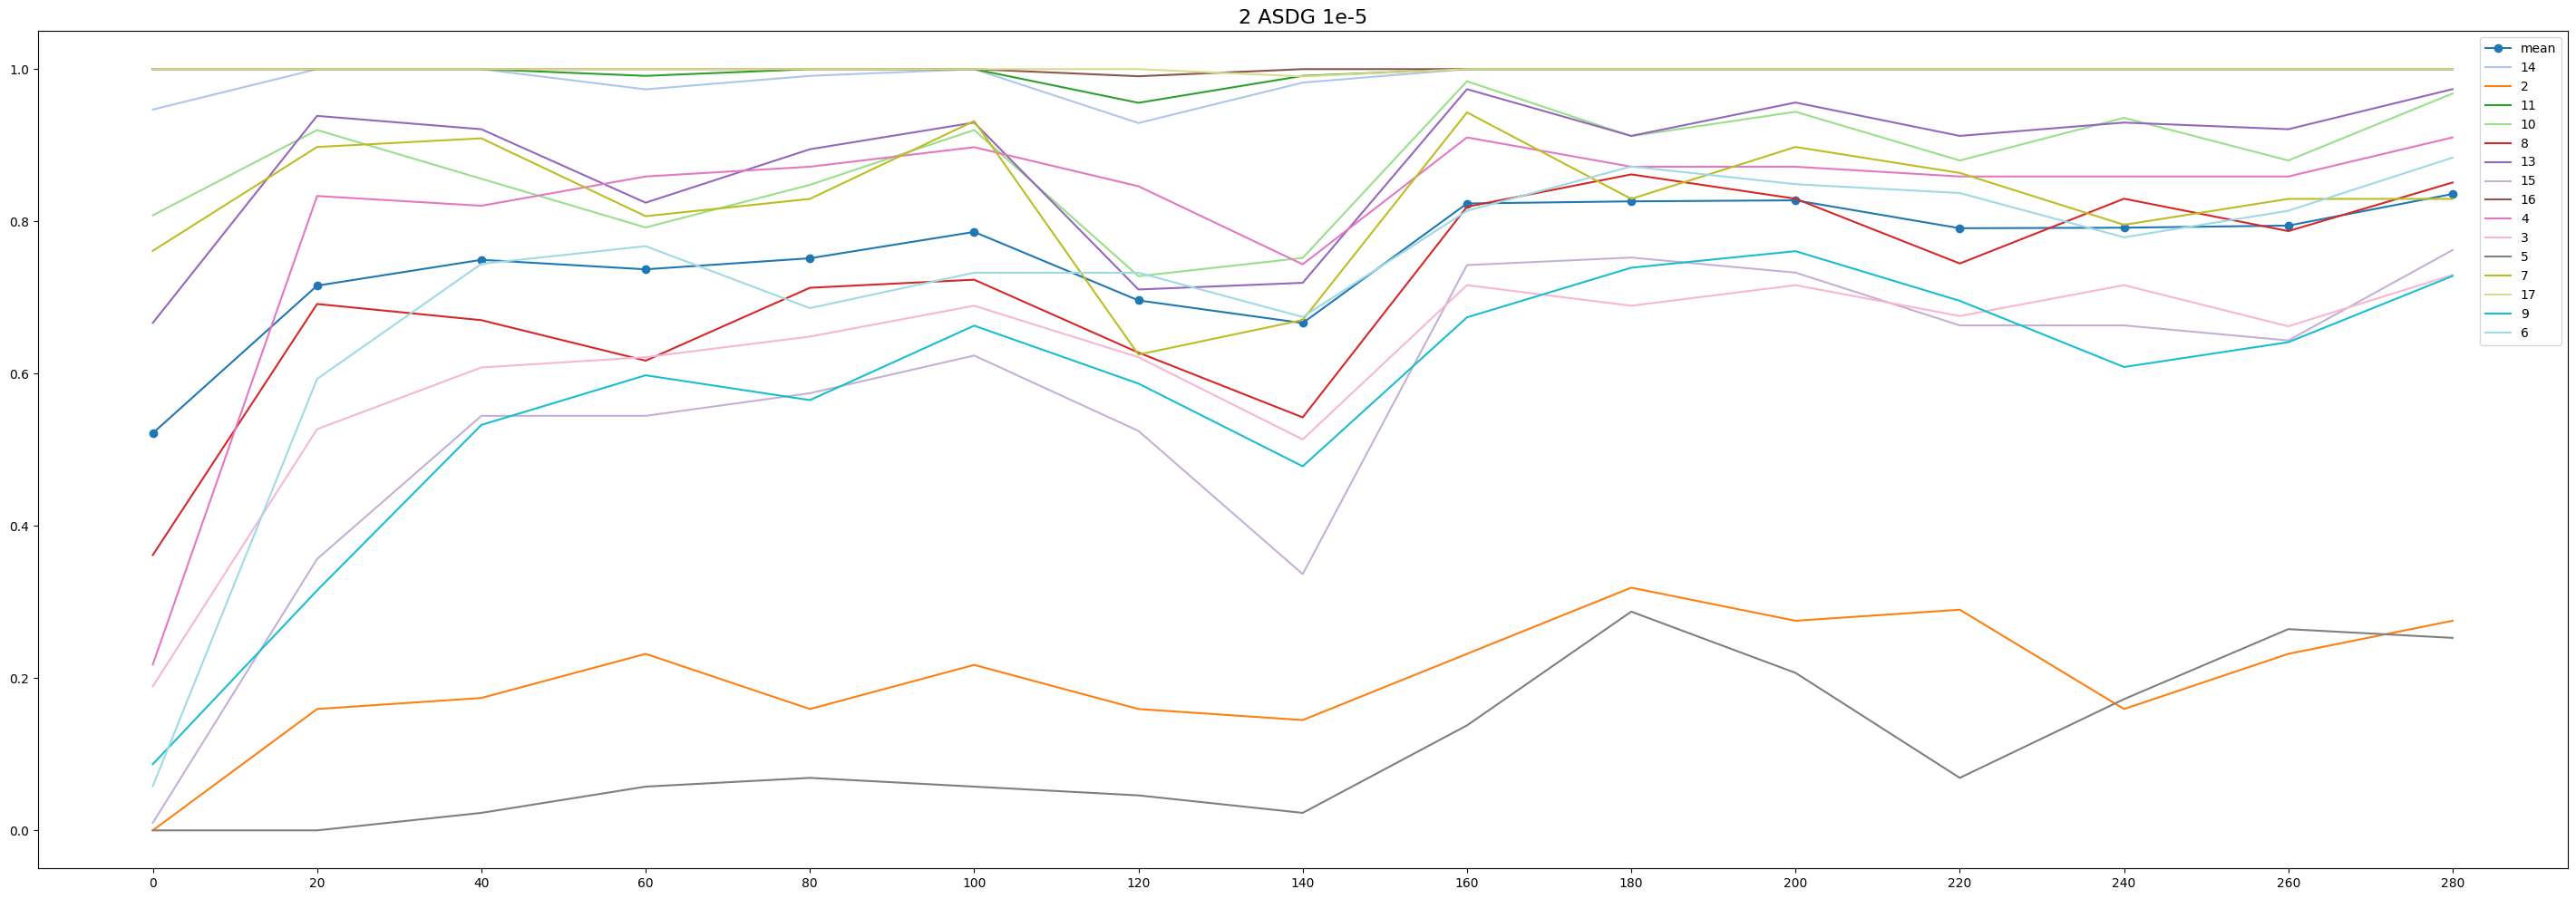

In [86]:
_plt(epochs_2_asgd_1, for_plot_2_asgd_1, "2 ASDG 1e-5", figsize=figsize)
pass

---

In [20]:
best_info_filename = (
    Path("NetUpDownCoder3_ASGD_lr_5e-05")
    / "NetUpDownCoder3_ASGD_lr_5e-05_best.pkl"
)
with open(best_info_filename, "rb") as f:
    best_info = pickle.load(f)
r = {
    "mean": best_info.get("rate"),
    "subjects": subjects_validate(best_info.get("net_state_dict")),
}

In [27]:
best_info.get("current_epoch")

7

---

## Check data

In [ ]:
# for subject_id, data in all_data.items():
#     print(f"{str(subject_id): <2}", end=": ")
#     for subject_data in data:
#         t = torch.tensor(
#             subject_data.get("working_data_filtered").get("RR_list_cor")
#         )
#         print((round(t.mean().item(), 3), round(t.std().item(), 3)), end="; ")
#     print()

In [ ]:
# train_9 = DriverDataset(
#     all_data.get(9),
#     ds_type="train",
#     data_field="working_data_filtered",
#     step=ds_step_size,
# )

In [ ]:
# len(train_9)

In [42]:
from torch.utils.tensorboard import SummaryWriter

In [43]:
test = Path("test_writer")
writer = SummaryWriter(test)

In [44]:
for i in range(50):
    writer.add_scalars(
        "cmp",
        {
            "doubled": i * 2,
            "powered": i**2,
            "module 5": i % 5,
        },
        i,
    )